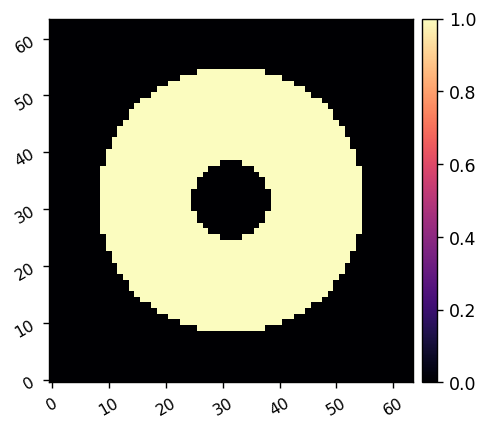

In [2]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc
from matplotlib.patches import Circle
from importlib import reload
reload(misc)

data_dir = Path('C:/Users/Kian/Documents/data-files/disk-processing')
# data_dir = Path('/users/kianmilani/Documents/data-files/disk-processing')
# data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf=64
psf_pixelscale_mas = 21.82142167566928*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)
psf_pixelscale_m = psf_pixelscale*u.m/u.pix

polaxis = 10

ndisk = 64
disk_pixelscale_mas = 20.8*u.mas/u.pix
disk_pixelscale_lamD = (disk_pixelscale_mas/mas_per_lamD).value

band1_wavelength = 575e-9*u.m
iwa_band1 = 2.8
owa_band1 = 9.7

iwa = iwa_band1 * wavelength_c/band1_wavelength
owa = owa_band1 * wavelength_c/band1_wavelength

iwa_mas = iwa*mas_per_lamD
owa_mas = owa*mas_per_lamD

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
r = np.sqrt(x**2 + y**2)*disk_pixelscale_lamD
mask = np.zeros((ndisk,ndisk))
mask[((r>iwa)*(r<owa))] = 1
misc.myimshow(mask)

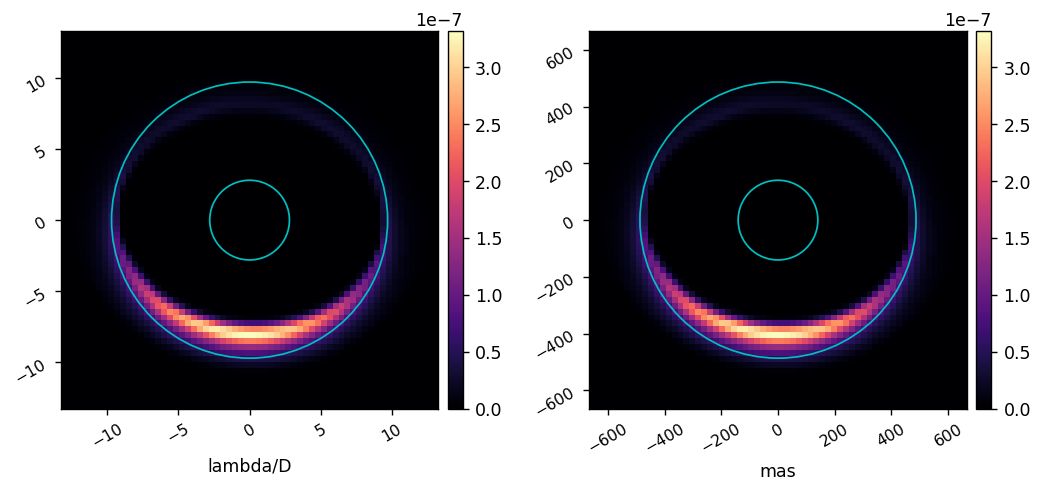

In [20]:
disk_fpath = data_dir/'disks'/'I_0_eps_eri.fits'
disk_fpath = data_dir/'disks'/'I_0_hlc.fits'
disk_fpath = data_dir/'disks'/'I_45_hlc.fits'
disk_fpath = data_dir/'disks'/'I_90_hlc.fits'
disk_fpath = data_dir/'disks'/'I_135_hlc.fits'
disk_fpath = data_dir/'disks'/'disk_new.fits'

disk = fits.getdata(disk_fpath)
disk = misc.pad_or_crop(disk, ndisk)
disk_hdr = fits.getheader(disk_fpath)

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk, lognorm1=False, lognorm2=False, 
               pxscl1=disk_pixelscale_lamD, pxscl2=disk_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )


# Do the matrix multiplication

In [21]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20230221.hdf5'

f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

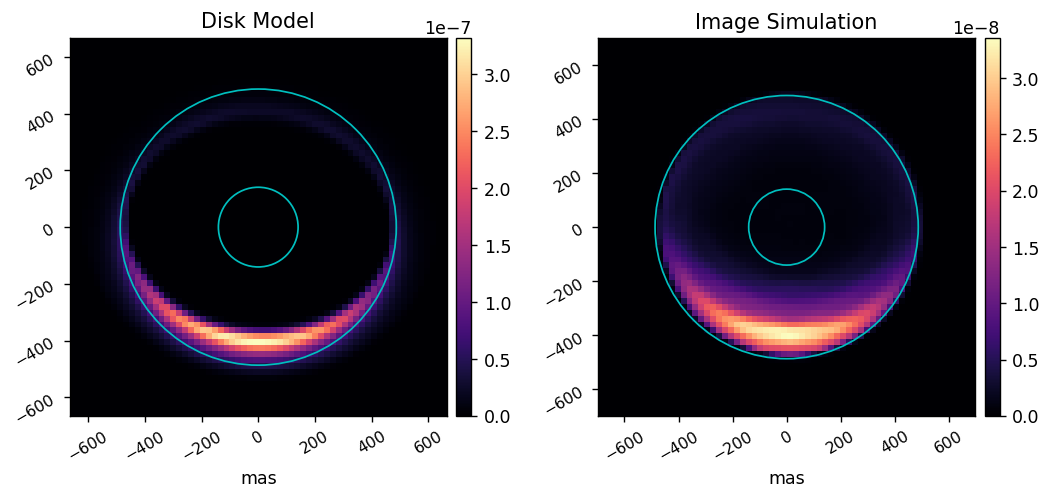

In [23]:
disk_sim = np.reshape(ipsf_matrix.dot(disk.flatten()), (npsf,npsf))

patches1 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk_sim,
               'Disk Model', 'Image Simulation',
               pxscl1=disk_pixelscale_mas, pxscl2=psf_pixelscale_mas,
               patches1=patches1, patches2=patches2)

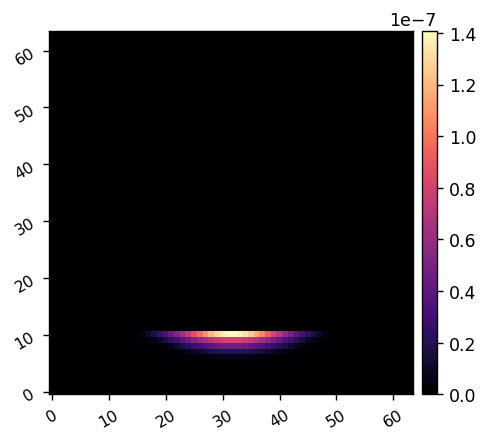

In [32]:
new_disk = disk.flatten()
new_disk[704:] = 0
misc.myimshow(new_disk.reshape(ndisk,ndisk))

In [29]:
64*10

640

In [7]:
import misc_funs as misc
ndisk = 64
disk_pixelscale_mas = 20.8*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix

start = ipsf_matrix.shape[0]//2
for i in range(start, ipsf_matrix.shape[0]):
    new_disk = disk.flatten()
    new_disk[i:] = 0
    disk_sim = np.reshape(ipsf_matrix.dot(new_disk), (npsf,npsf))
    
    patches = [Circle((x[i].value, y[i].value), 20, color='c', fill=False)]
    try:
        fig,ax = misc.imshow3(ipsf_matrix[:,i].reshape(npsf,npsf), new_disk.reshape(ndisk,ndisk), disk_sim,
                       'x={:.2f}, y={:.2f}'.format(x[i], y[i]), 
                     pxscl1=psf_pixelscale_mas, pxscl2=disk_pixelscale_mas, pxscl3=psf_pixelscale_mas,
                     patches2=patches,
                       lognorm1=True, return_fig=True)
        clear_output(wait=True)
    except KeyboardInterrupt:
        break

<Figure size 1250x500 with 0 Axes>

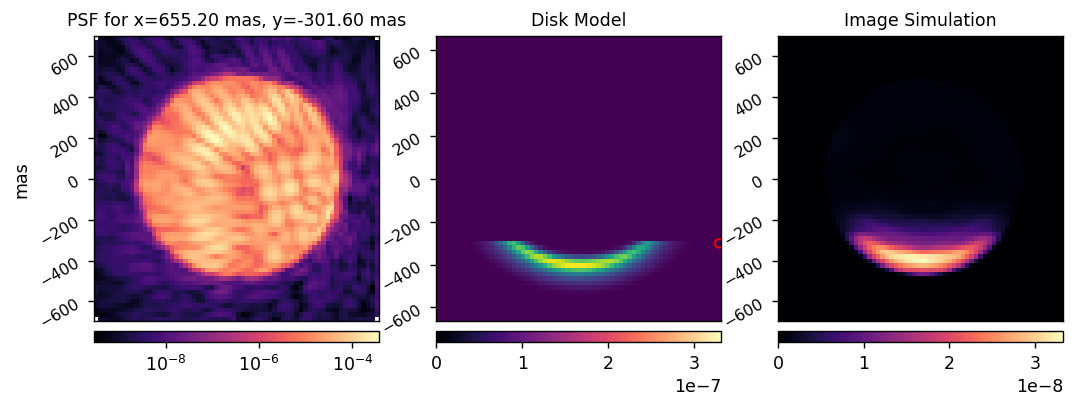

In [35]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\Kian\\ffmpeg\\ffmpeg-2023-02-19-git-2aec86695a-full_build\\bin\\ffmpeg.exe'

ndisk = 64
disk_pixelscale_mas = 20.8*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix

i = 0
i = ndisk**2//2
new_disk = disk.flatten()
new_disk[i:] = 0
disk_sim = np.reshape(ipsf_matrix.dot(new_disk), (npsf,npsf))

fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4), dpi=125)
titlesize = 10

ax[0].set_ylabel('mas')
ext1 = psf_pixelscale_mas.value * npsf/2
extent1 = [-ext1,ext1,-ext1,ext1]
extent3 = extent1
ext2 = disk_pixelscale_mas.value * ndisk/2
extent2 = [-ext2,ext2,-ext2,ext2]

# first plot
im = ax[0].imshow(ipsf_matrix[:,i].reshape(npsf,npsf), cmap='magma', norm=LogNorm(), extent=extent1)
ax[0].set_xticks([])
ax[0].tick_params(axis='x', labelsize=9, rotation=30)
ax[0].tick_params(axis='y', labelsize=9, rotation=30)
tx1 = ax[0].set_title('PSF for x={:.2f}, y={:.2f}'.format(x[i], y[i]), fontsize=titlesize)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="4%", pad=0.075)
fig.colorbar(im, cax=cax, orientation='horizontal')

# second plot
im = ax[1].imshow(new_disk.reshape(ndisk,ndisk), cmap='magma', extent=extent2)
ax[1].set_xticks([])
ax[1].tick_params(axis='x', labelsize=9, rotation=30)
ax[1].tick_params(axis='y', labelsize=9, rotation=30)
ax[1].set_title('Disk Model', fontsize=titlesize)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="4%", pad=0.075)
fig.colorbar(im, cax=cax, orientation='horizontal')

# third plot
im = ax[2].imshow(disk_sim, cmap='magma', extent=extent3, aspect='equal')
ax[2].set_xticks([])
ax[2].tick_params(axis='x', labelsize=9, rotation=30)
ax[2].tick_params(axis='y', labelsize=9, rotation=30)
ax[2].set_title('Image Simulation', fontsize=titlesize)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("bottom", size="4%", pad=0.075)
fig.colorbar(im, cax=cax, orientation='horizontal')

def animate(i=ndisk**2//2):
    i += 640
    new_disk = disk.flatten()
    new_disk[i:] = 0
    disk_sim = np.reshape(ipsf_matrix.dot(new_disk), (npsf,npsf))
    
    ax[0].imshow(ipsf_matrix[:,i].reshape(npsf,npsf), cmap='magma', extent=extent1, norm=LogNorm())
    tx1.set_text('PSF for x={:.2f}, y={:.2f}'.format(x[i], y[i]))
    
    ax[1].imshow(new_disk.reshape(ndisk,ndisk), cmap='viridis', extent=extent2)
    [p.remove() for p in reversed(ax[1].patches)] # remove the previous patches
    ax[1].add_patch(Circle((x[i].value, y[i].value), 20, color='r', fill=False))
    
    ax[2].imshow(disk_sim, cmap='magma', extent=extent3)
            
ani = FuncAnimation(fig, animate, frames=512, interval=100, repeat=False)
FFwriter = animation.FFMpegWriter()
ani.save('image_convolution_anim.mp4', writer=FFwriter)

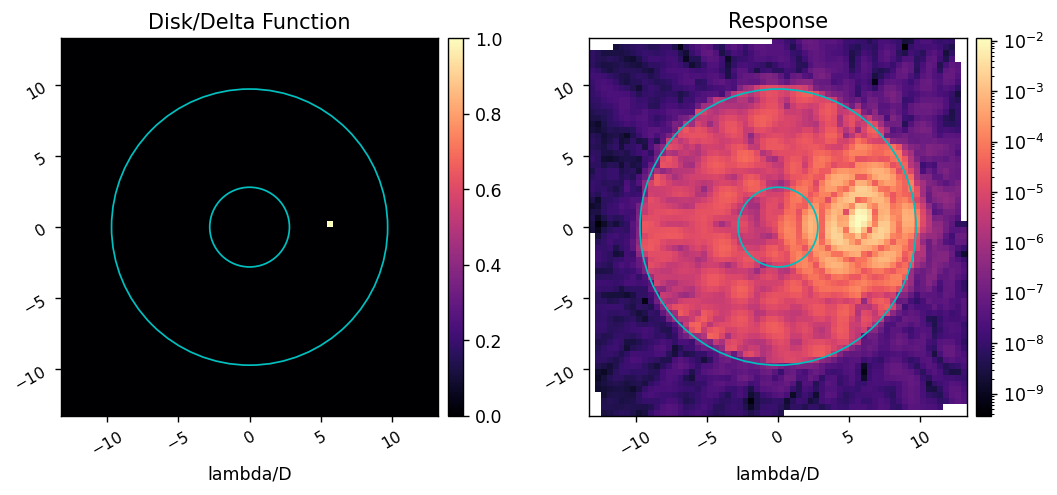

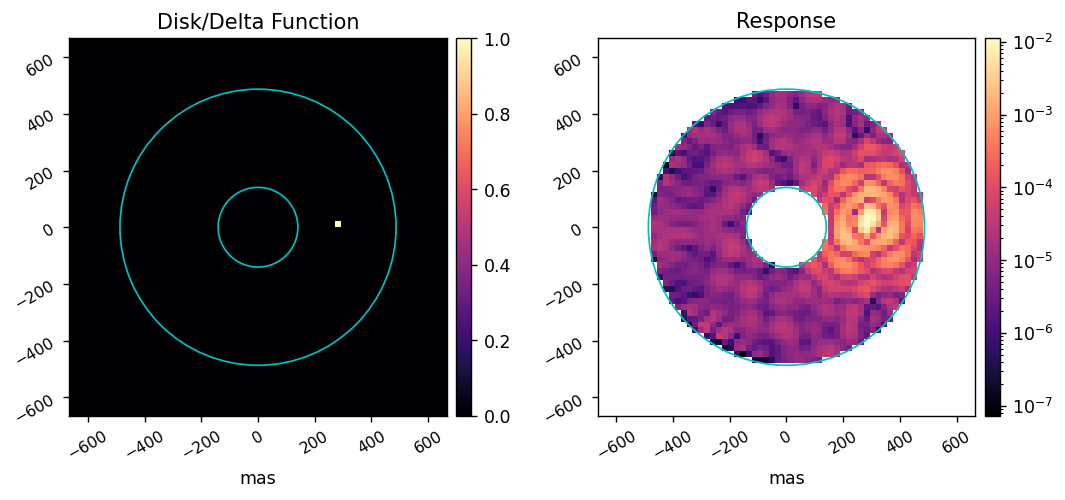

1.0 0.22915871060030296 0.22915871060030296 0.011094788100797554


In [6]:
patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
misc.myimshow2(disk, disk_sim, 'Disk/Delta Function', 'Response',
               lognorm1=False, 
               lognorm2=True, 
               pxscl1=disk_pixelscale_lamD, pxscl2=disk_pixelscale_lamD, 
               patches1=patches1, patches2=patches2 )

patches1 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk*mask, disk_sim*mask, 'Disk/Delta Function', 'Response',
               lognorm1=False, 
               lognorm2=True, 
               pxscl1=disk_pixelscale_mas, pxscl2=disk_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )

disk_sum = (mask*disk).sum()
im_sum = (mask*disk_sim).sum()

print(disk_sum, im_sum, im_sum/disk_sum, disk_sim.max())

In [9]:
data = np.zeros((2,ndisk,ndisk))
data[0] = disk
data[1] = disk_sim

hdr = fits.Header()
hdr['PIXELSCL'] = 20.8
hdr['DELTASRC'] = 270

data_fits = fits.PrimaryHDU(data=data, header=hdr)
data_fits.writeto('delta_simulation.fits', overwrite=True)